# COS 3a Exercise 9

---
Submission until 17/12/2024 12:00 p.m.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Tutorial

### Molecular Dynamics 

In the lecture, some integrators to solve the ordinary differential equation (ODE) associated with the equation of motion (EOM) were presented. In the context of molecular dynamics (MD) simulations, we want to describe this motion of a (classical, molecular) system over time. 
One of the integrators we will concentrate on in this exercise is the so-called [Leapfrog](https://en.wikipedia.org/wiki/Leapfrog_integration) algorithm. In general, the EOM is an ODE that can be written as: 
$$
\dot{v} = \frac{d v(x)}{dt} = A(x)
$$
The Leapfrog algorithm now proposes a numerical solution to this ODE by updating velocities at half time steps and positions at full time steps, namely:
\begin{align}
a_i = A(x_i) \\
v_{i+1/2} = v_{i-1/2} + a_i \Delta t \\
x_{i+1} = x_i + v_{i+1/2} \Delta t
\end{align}
where $a_i$ is the acceleration, $x_i$ the position and $v_i$ the velocity at time step $i$. 
Alternative variants for integrators are the (Velocity) Verlet algorithm, that have been introduced briefly in the lecture as well.

### Interatomic Potentials

Since we need to model the potential energy surface (PES) of our system, we need to express the energy $E$ as a function of atom positions in some way. For the purpose of this exercise, we will use a trivial harmonic model potential - the harmonic oscillator potential - and provide a more involved mixed potential comprising intramolecular bond and angle terms ([force-field](https://en.wikipedia.org/wiki/Force_field_(chemistry)) like potential) and an intermolecular [Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) potential, which you can optionally expand to also involve Coulomb interactions. 
In principle you can carry out MD simulations with arbitrarily complex molecular systems given that a description of the PESs can be accomplished. This can range, for example, from force-field MDs of large biomolecules to $ab~initio$ MDs of small(er) molecules or condensed systems. The essential quantitites you need to set up an MD simulation are the nuclear forces (acceleration) and an integrator letting you propagate your system in time. The atom positions and velocities of the particles need to be updated.


## Task 1

In this exercise, we want to implement the Leapfrog algorithm for a simple 1D harmonic oscillator (HO) potential given as:
$$
U(x) = \frac{1}{2} k x^2
$$
where $U$ is the potential energy and $k$ is the "spring" or harmonic constant and $x$ is the (displacement from the equilibrium) position. 

Derive an expression to compute the force (see also lecture) of the harmonic potential. 

Implement a function to compute the harmonic potential and the nuclear force. Use the standard input parameters given below as **optional** arguments for your function. 

Based on this model system, implement the Leapfrog algorithm to propagate this 1D particle in time. Think of reasonable starting conditions for your model systems.

Visualize the particle position and velocity in a plot and briefly describe what you see (max 2 sentences).

In [2]:
dt = 0.01  # Time step (a.u.) 
k = 8.0 # Harmonic constant
npart = 1
N = 1000 # Number of steps to propagate the system

<span style="color:red"> Solution: </span>

The nuclear force is given as $F(x) = -\frac{dU(x)}{dx}$.

In [3]:
def U_HO(x: np.array, k: float = 1.0):
    """ Energy and force function for harmonic oscillator.

    Args:
        x (np.array): Displacements from equilibrium position.
        k (float): Spring constant. Defaults to 1.0.

    Returns:
        U (float): Potential energy.
        F (np.array): Nuclear forces.
    """

    U = 0.5 * k * np.sum(x**2)  
    F = -k * x  
    
    return U, F

In [4]:
def LFstep(x: np.array, m: np.array, Ecalc: callable, vi: np.array, dt: float = 0.01, **kwargs):
    """
    Perform one step of the Leapfrog integration.
    
    Args:
        x (np.array): Current positions.
        m (np.array): Masses of the particles.
        Ecalc (callable): Function to compute the energy and force.
        vi (np.array): Initial velocities.
        dt (float): Time step for propagation (default: 0.01).
        **kwargs: Additional parameters for energy calculator.

    Returns:
        x_new, v_new, F_new (np.array): Updated positions, velocities, forces.
    """

    # Generate initial force
    _, Fi = Ecalc(x, **kwargs)  

    # Eq. 2
    v_half = vi + 0.5 * Fi / m * dt

    # Eq. 3 
    x_new = x + v_half * dt

    # Compute new force
    _, F_new = Ecalc(x_new, **kwargs)

    # Eq. 3 
    v_new = v_half + 0.5 * F_new / m * dt

    return x_new, v_new, F_new


def runLF(x: np.array, m: np.array, v: np.array, Ecalc: callable, nsteps: int, dt: float = 0.01, **kwargs):
    """
    Run particle MD with Leapfrog integration.

    Args:
        x (np.array): Initial positions.
        m (np.array): Masses of the particles.
        v (np.array): Initial velocities.
        Ecalc (callar_ohe): Function to compute energy and force.
        nsteps (int): Number of steps to integrate.
        dt (float): Time step for propagation (default: 0.01).
        **kwargs: Additional parameters for Ecalc.
    
    Returns:
        dict: Contains positions, velocities, forces, and energies over time.
    """
    # Initialize storage arrays
    positions = [x]
    velocities = [v]
    kinetic_energies = [0.5 * np.sum(m * v**2)]
    potential_energies = [Ecalc(x, **kwargs)[0]]
    total_energies = [kinetic_energies[-1] + potential_energies[-1]]

    # Initialize force
    _, F = Ecalc(x, **kwargs)

    # Simulation loop
    for _ in range(nsteps):
        x, v, F = LFstep(x, m, Ecalc, v, dt, **kwargs)
        
        # Record data
        positions.append(x)
        velocities.append(v)
        kinetic_energies.append(0.5 * np.sum(m * v**2))
        potential_energies.append(Ecalc(x, **kwargs)[0])
        total_energies.append(kinetic_energies[-1] + potential_energies[-1])

    # Convert lists to arrays and store as dictionary for clear returns
    return {
        "positions": np.array(positions),
        "velocities": np.array(velocities),
        "forces": F,
        "kinetic_energies": np.array(kinetic_energies),
        "potential_energies": np.array(potential_energies),
        "total_energies": np.array(total_energies),
    }

    

In [5]:
x0 = np.ones(npart)  # Initial position
v0 = np.zeros(npart)  # Initial velocity
m = np.ones(npart)  # Particle mass

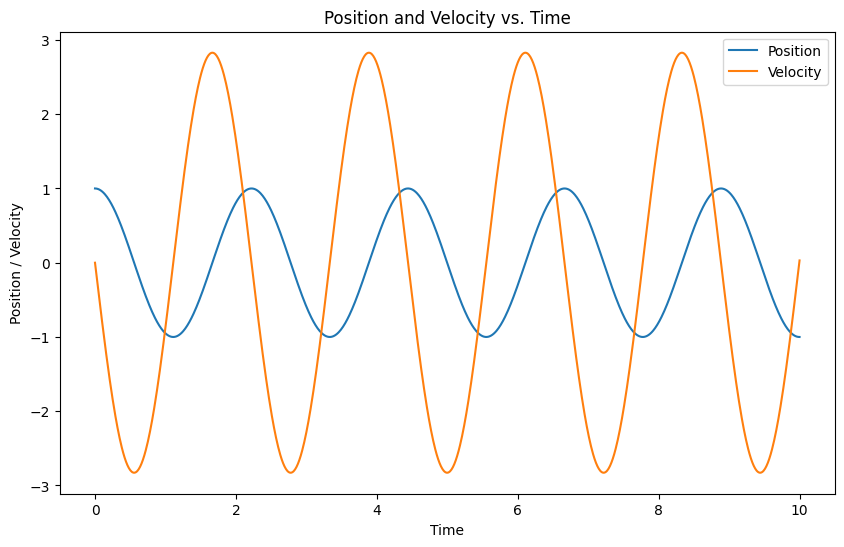

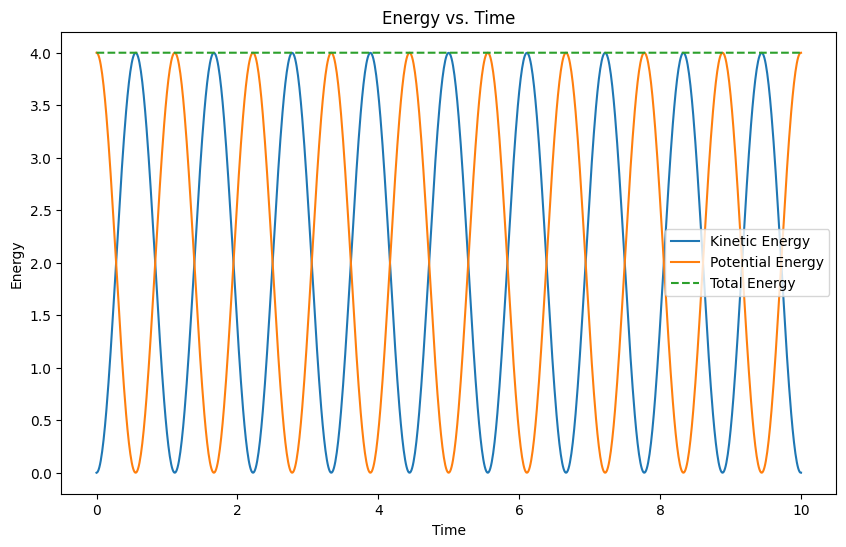

In [6]:
results = runLF(x0, m, v0, U_HO, nsteps= N, dt=dt, k=k)

# Plot results
time = np.arange(N + 1) * dt
plt.figure(figsize=(10, 6))
plt.plot(time, results["positions"], label="Position")
plt.plot(time, results["velocities"], label="Velocity")
plt.xlabel("Time")
plt.ylabel("Position / Velocity")
plt.legend()
plt.title("Position and Velocity vs. Time")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time, results["kinetic_energies"], label="Kinetic Energy")
plt.plot(time, results["potential_energies"], label="Potential Energy")
plt.plot(time, results["total_energies"], label="Total Energy", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.title("Energy vs. Time")
plt.show()

### Task 2

<span style="color:red"> Add description of NVT vs NVE, Langevin Thermostat </span>


For this task, we try to adapt the model presented in [this article](https://www.sciencedirect.com/science/article/pii/S0378381207005912), which features a LJ-type potential for water MD simulations.
The intraatomic potential expression reads:
\begin{align}
U_\mathrm{intra} = \frac{1}{2} K_r (r-r_0)^2 + \frac{1}{2} K_\theta (\theta - \theta_0)^2
\end{align}\tag{6}
whereas the interatomic potential reads:
\begin{align}
U_\mathrm{inter}(r_ij) = 4\epsilon_{ij} \left[ \left(\frac{\sigma_{ij}}{r_{ij}}\right)^{12} - \left(\frac{\sigma_{ij}}{r_{ij}}\right)^{6} \right] + \frac{q_i q_j}{4 \pi \epsilon_0 r_{ij}}
\end{align}\tag{7}
As can be seen, we have an expression similar to what is known from molecular force-fields in the intraatomic potential, where a bond distance and angle term are contained. 
The 6-12-LJ interatomic potential contains an additional Coulomb term with fixed partial atomic charges.  
To begin with, we define all constants in the following and define our system of water molecules to model. Table 1 of the mentioned article reads:
|    Parameter   | Value          |   
|----------------|--------------
| $R_\mathrm{OH}~(\mathrm{\AA})$       | 0.9611        
 | $K_r~(\mathrm{kJ\cdot mol^{-1} \cdot\AA^{-2}})$ | 1480              |
| $\theta_\mathrm{HOH}~(°)$       | 109.47         
| $K_\theta~(\mathrm{kJ\cdot mol^{-1} \cdot\AA^{-2}})$  | 353               |
| $q_\mathrm{H}~(\mathrm{e})$         | 0.4238        
| $q_\mathrm{O}~(\mathrm{e})$         | −0.8476        
| $\epsilon_\mathrm{H}~(\mathrm{kJ/mol})$     | 0.0324             |
| $\epsilon_\mathrm{O}~(\mathrm{kJ/mol})$     | 0.6287             |
| $\sigma_\mathrm{H}~(\mathrm{\AA})$        | 0.98               |
| $\sigma_\mathrm{O}~(\mathrm{\AA})$       | 3.1169       

Write brief explanations about the functions provided in `ljpot2` (max 3 sentences each). <span style="color:red"> Do not just copy & paste the function description! </span>

Analyze the influence of 3 different simulation parameters on the MD simulation of the water ensemble and describe your findings with bullet points in markdown. Support your analysis with useful plots. Here is a list of options to choose from:

- Simulation Temperature $T$ 
- Periodic Boundary Conditions
- Neglecting different terms to model the potential energy (e.g. omitting Coulomb potential in $U_\mathrm{inter}$)
- Varying model parameters that affect the energy, e.g. $q_i$, $r_\mathrm{OH}$
- ...

Give three suggestions on how the MD simulation can be improved in regard to, e.g. the accuracy, performance.

In [7]:
# Import modules for this exercise
import ljpot as ljp

# Model constants
r_oh = 0.9611 # Angstrom
k_r = 1480.0 / 2 # Involves factor of 1/2 from potential expression and unit rescaling 
theta_hoh = np.radians(109.47) # Angle in radians
k_theta = 353.0 / 2 

# Epsilon and sigma matrices containg atom and pair parameters according to eq. 3 and 4, readjusted
eps_h = 0.0324 
eps_o = 0.6287
sig_h = 0.98
sig_o = 3.1169

eps = np.array([
    [eps_h + eps_h, eps_h + eps_o], 
              [eps_h + eps_h, eps_o + eps_o]
              ])
eps *= 0.5 # Eq. 3 in article


sig = np.array([
    [sig_h * sig_h, sig_h * sig_o], 
              [sig_h * sig_o, sig_o * sig_o]
              ])
sig = np.sqrt(sig) # Eq. 4 in article

# Masses and charges of atom types
mass_ = np.array([1.0, 16.0])
qs_ = np.array([0.4238, -0.8476])

In [8]:
# Define physical system to perform MD simulation with

n = 21 # Number of particles
D = 3 # Dimensionality of the system 
dt = 0.0001 # Time step (in ps)
blength = 20.0 # Molecular box volume (in Angstrom)

#Initialize random positions and velocities of particles
np.random.seed(1000)
x_init = np.random.rand(n, D) * blength 
v_init = np.random.rand(n, D) - 0.5 

T = 300 # Simulation temperature (in K) 

#set dimensions of box where MD is run in
L = np.zeros([D]) + blength

In [9]:
# Helper function to construct the water model system based on initial paramters  
model = ljp.build_model(nmol = n,
                bdist= r_oh,
                kbond= k_r,
                theta= theta_hoh, 
                ktheta = k_theta,
                ms = mass_,
                qs = qs_)

# Extract quantities for simulation from model dictionary
#bonds = model['bonds']
#angles = model['angles']
#atomtypes = model['attypes']
#molecules = model['mols']
#masses = model['masses']
#charges = model['charges']

In [10]:
ddir = "_dumps"
nsteps, nskip = 2000, 20
num_steps = int(nsteps/nskip) # Anzahl der Zeitschritte

ljp.run_MD(model = model,
            xin = x_init,
            vin= v_init,
            dt = dt,
            L = L,
            sigma= sig,
            epsilon= eps,
            simT= T,
            nstep=nsteps,
            nskip=nskip,
            dumpdir=ddir,
            doPBC=False
            )

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import os

def read_positions_from_dump(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    positions = []
    for line in lines:
        if line.startswith("ITEM: ATOMS"):
            break
    
    for line in lines[lines.index(line) + 1:]:
        parts = line.split()
        if len(parts) == 6:
            id, mol, type, x, y, z = parts
            positions.append([float(x), float(y), float(z), int(type)])
    
    return np.array(positions)

def create_animation(dump_folder, num_steps, outname, Title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    def init():
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 20)
        ax.set_zlim(0, 20)
        return []

    def update(frame):
        ax.clear()
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 20)
        ax.set_zlim(0, 20)
        ax.set_title(f'{Title}\nTime step: {frame}')
        
        file_path = os.path.join(dump_folder, f't{frame}.dump')
        positions = read_positions_from_dump(file_path)
        
        for i in range(0, len(positions), 3):
            # Zeichne die Atome
            ax.scatter(positions[i:i+3, 0], positions[i:i+3, 1], positions[i:i+3, 2], color=['red', 'blue', 'red'])
            
            # Verbinde die Atome miteinander
            # ax.plot(positions[i:i+3, 0], positions[i:i+3, 1], positions[i:i+3, 2], color='black')
        
        return []

    ani = FuncAnimation(fig, update, frames=num_steps, init_func=init, blit=False, interval=100)
    ani.save(outname, writer='ffmpeg')
    plt.close()

In [12]:
for temp in [300, 500]:
    ljp.run_MD(model = model,
                xin = x_init,
                vin= v_init,
                dt = dt,
                L = L,
                sigma= sig,
                epsilon= eps,
                simT= temp,
                nstep=nsteps,
                nskip=nskip,
                dumpdir=ddir,
                doPBC=False
                )
    create_animation(ddir, num_steps, f'T{temp}.mp4', f'T = {temp} K')

### Modify $\epsilon$

In [13]:
eps_h = 0.324 # x 10
eps_o = 0.6287
sig_h = 0.98
sig_o = 3.1169

epsmod = np.array([
    [eps_h + eps_h, eps_h + eps_o], 
              [eps_h + eps_h, eps_o + eps_o]
              ])
epsmod *= 0.5 # Eq. 3 in article

In [14]:
#nsteps, nskip = 2000, 20
#temp = 700
#num_steps = int(nsteps/nskip) # Anzahl der Zeitschritte
ljp.run_MD(model = model,
                xin = x_init,
                vin= v_init,
                dt = dt,
                L = L,
                sigma= sig,
                epsilon= epsmod,
                simT= temp,
                nstep=nsteps,
                nskip=10,
                dumpdir=ddir,
                doPBC=True
                )
create_animation(ddir, num_steps, f'epsmod.mp4', f'T = {temp} K')